# Task 3 - Predict the PD (Probability of default) for a borrower

**Aim**
Use the provided data to train a function that will estimate the probability of default for a borrower.

**Objectives**
1. Produce a function that can take in the properties of a loan and output the  expected loss.
2. Explore some technique including
> * Simple regression: -- Accuracy of the Logistic Regression model is:  0.99; Accuracy of Logisitic Regression model after replace variable is: 0.9979
> * XGBoost: -- Accuracy of the XGBoost is 0.9998
> * Random forest: -- Accuracy of the Random Forest model is 0.9997


3. Use multiple methods and provide a comparative analysis.

**Raw data info:**
- borrower
- income
- total loans outstanding
- Previsouly defaulted on a loan
- Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.



In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics  import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/Hongyan-Wang/JP_Morgan_Project/main/Task_3_4_Loan_Data.csv'
df = pd.read_csv(url)
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


# Exploratory Data Analaysis


## 1. Check out the misssing data

 - It is found that their is no missing data in this data set
 - No need to conduct pre-processing/ data wrangling for now


## 2. Check the distribution of some key variables



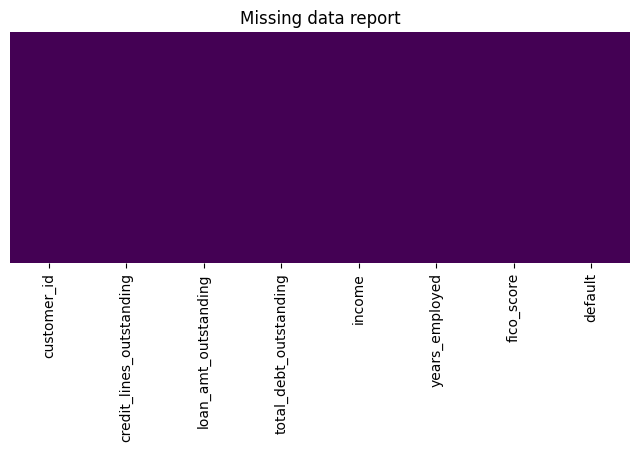

In [3]:
fig, ax1 = plt.subplots(figsize = (8,3))
sns.heatmap(df.isnull(),yticklabels=False, cbar = False, cmap = 'viridis').set(title = 'Missing data report')
plt.show()

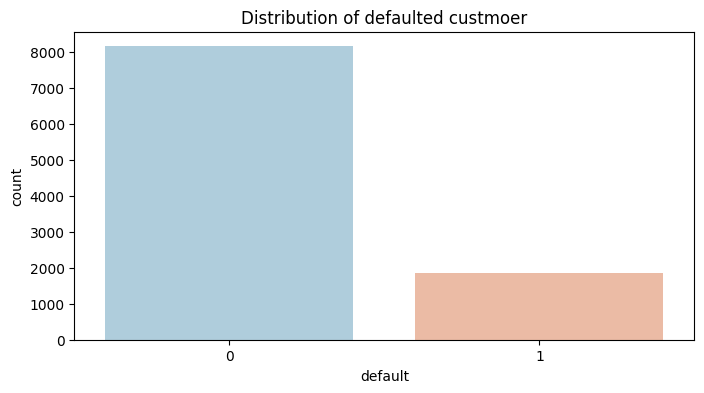

the percentage of defaulted customer is:  18.509999999999998  %


In [4]:
fig,ax1 =plt.subplots(figsize = (8, 4))
sns.countplot(x = 'default', data =df, palette= 'RdBu_r').set(title = 'Distribution of defaulted custmoer')
plt.show()
print('the percentage of defaulted customer is: ', sum(df.default)/len(df.index)* 100, ' %')

[Text(0.5, 1.0, 'Distribution of Years of employed')]

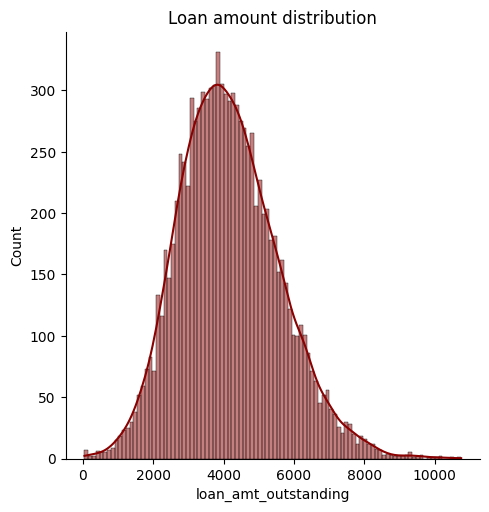

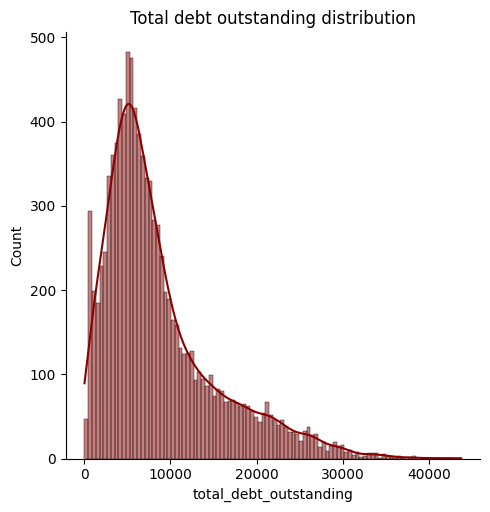

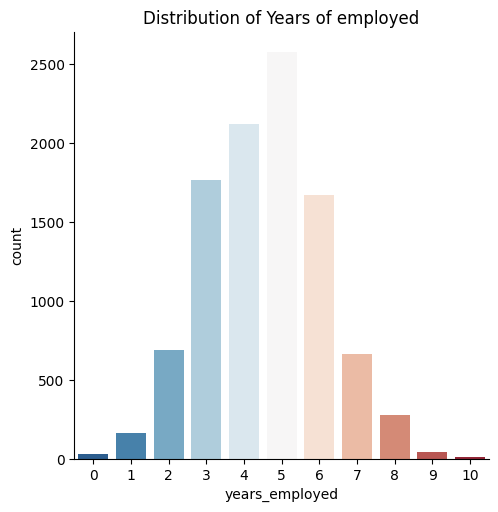

In [5]:
sns.displot(df.loan_amt_outstanding, kde = True, color = 'darkred', bins = 100).set(title = 'Loan amount distribution')
sns.displot(df.total_debt_outstanding, kde = True, color = 'darkred', bins = 100).set(title = 'Total debt outstanding distribution')
sns.displot(df.income, kde = True, color = 'darkred', bins = 100).set(title = 'Income distribution')
sns.countplot(x = 'years_employed', data =df, palette= 'RdBu_r').set(title = 'Distribution of Years of employed')

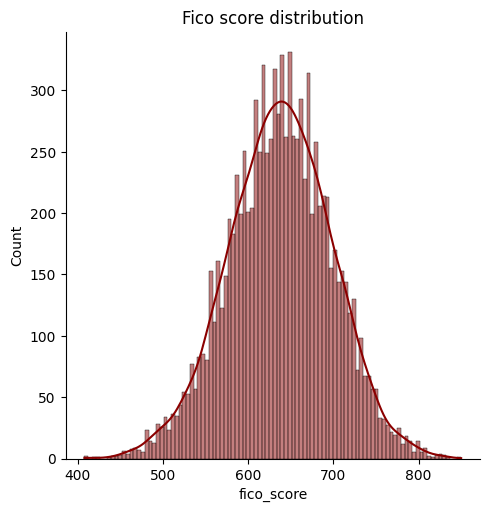

In [6]:
sns.displot(df.fico_score, kde = True, color = 'darkred', bins = 100).set(title = 'Fico score distribution')

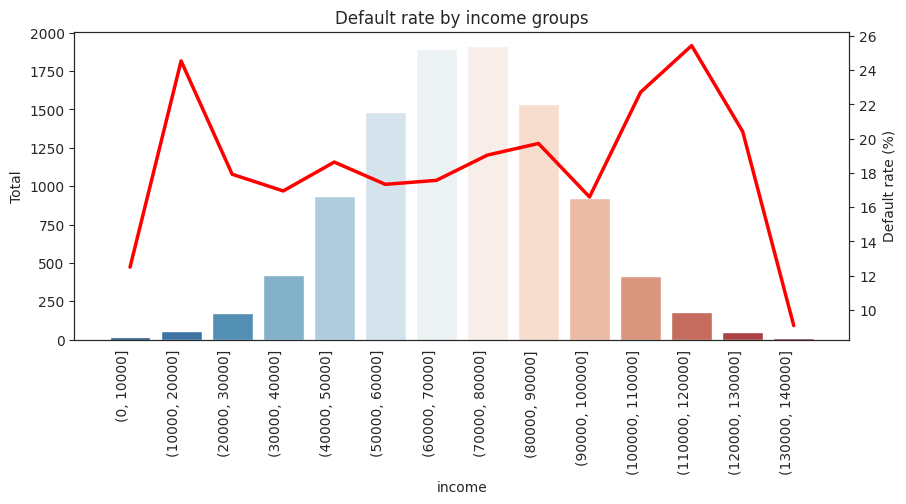

In [8]:
sns.set_style('white')
df_grouped = df.groupby([pd.cut(df['income'],np.arange(0, 150000, 10000)),'default']).size()
df_grouped1 = df_grouped.groupby(level = 0).apply(lambda x:x/x.sum() * 100).unstack(level = 'default').reset_index()
df_grouped1['Default rate (%)'] = df_grouped1[1]
df_grouped = df_grouped.groupby(level = 0).apply(lambda x: x).unstack(level = 'default').reset_index()
df_grouped['Total'] = df_grouped[0]+df_grouped[1]
fig, ax1 = plt.subplots(figsize = (10,4))
sns.barplot(data = df_grouped, x = 'income', y = 'Total', ax= ax1, palette = 'RdBu_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
ax2 = ax1.twinx()
sns.lineplot(data = df_grouped1, x = df_grouped1['income'].astype(str), y='Default rate (%)', ax = ax2, color = 'r', linewidth = 2.5).set(title = 'Default rate by income groups')
plt.show()

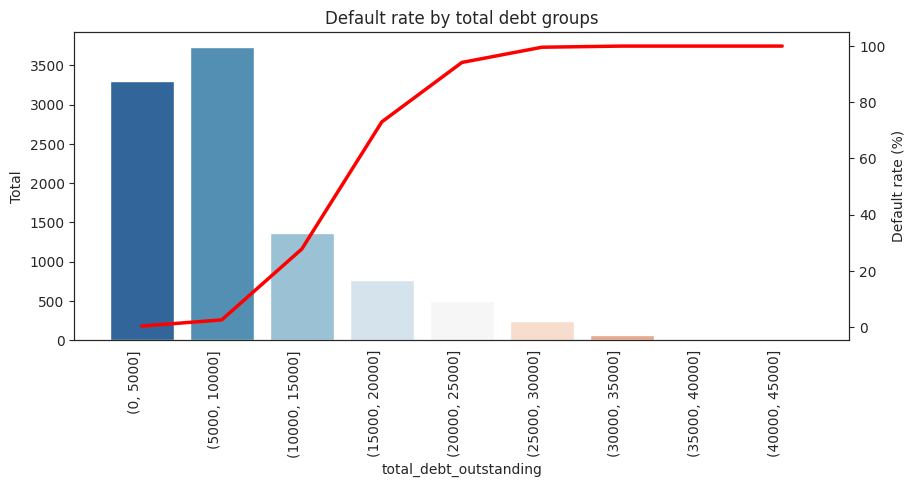

In [9]:
sns.set_style('white')
df_grouped = df.groupby([pd.cut(df['total_debt_outstanding'],np.arange(0, 50000, 5000)),'default']).size()
df_grouped1 = df_grouped.groupby(level = 0).apply(lambda x:x/x.sum() * 100).unstack(level = 'default').reset_index()
df_grouped1['Default rate (%)'] = df_grouped1[1]
df_grouped = df_grouped.groupby(level = 0).apply(lambda x: x).unstack(level = 'default').reset_index()
df_grouped['Total'] = df_grouped[0]+df_grouped[1]
fig, ax1 = plt.subplots(figsize = (10,4))
sns.barplot(data = df_grouped, x = 'total_debt_outstanding', y = 'Total', ax= ax1, palette = 'RdBu_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
ax2 = ax1.twinx()
sns.lineplot(data = df_grouped1, x = df_grouped1['total_debt_outstanding'].astype(str), y='Default rate (%)', ax = ax2, color = 'r', linewidth = 2.5).set(title = 'Default rate by total debt groups')
plt.show()

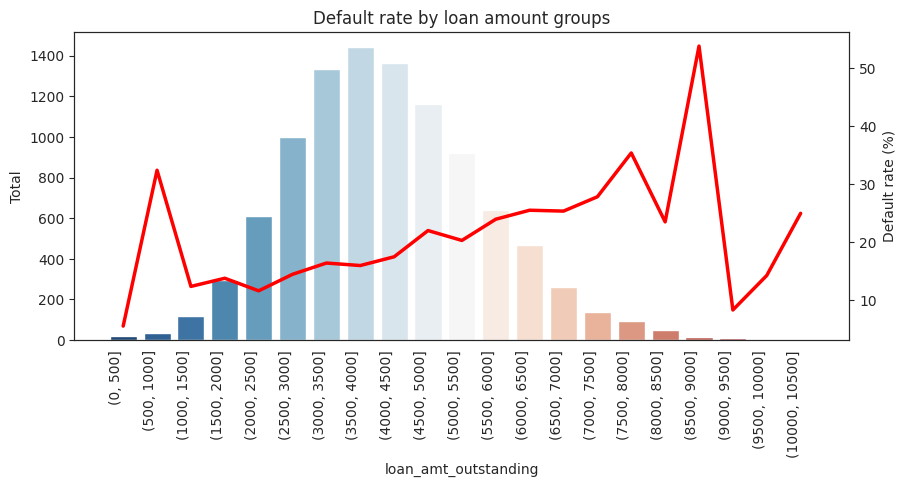

In [10]:
sns.set_style('white')
df_grouped = df.groupby([pd.cut(df['loan_amt_outstanding'],np.arange(0, 11000, 500)),'default']).size()
df_grouped1 = df_grouped.groupby(level = 0).apply(lambda x:x/x.sum() * 100).unstack(level = 'default').reset_index()
df_grouped1['Default rate (%)'] = df_grouped1[1]
df_grouped = df_grouped.groupby(level = 0).apply(lambda x: x).unstack(level = 'default').reset_index()
df_grouped['Total'] = df_grouped[0]+df_grouped[1]
fig, ax1 = plt.subplots(figsize = (10,4))
sns.barplot(data = df_grouped, x = 'loan_amt_outstanding', y = 'Total', ax= ax1, palette = 'RdBu_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
ax2 = ax1.twinx()
sns.lineplot(data = df_grouped1, x = df_grouped1['loan_amt_outstanding'].astype(str), y='Default rate (%)', ax = ax2, color = 'r', linewidth = 2.5).set(title = 'Default rate by loan amount groups')
plt.show()

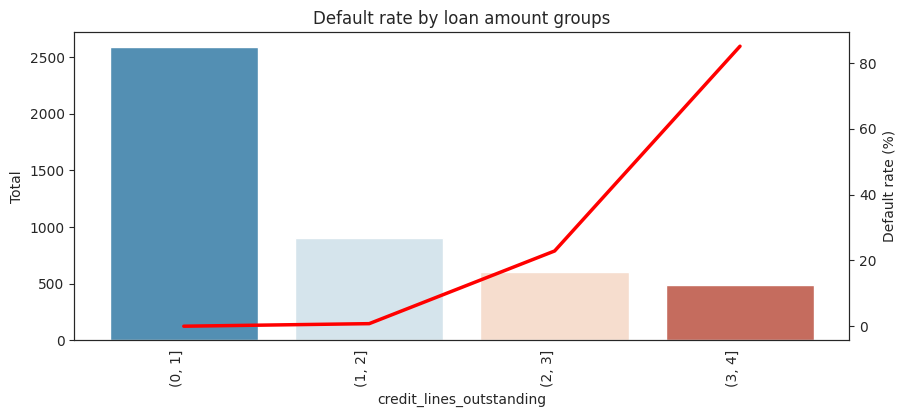

In [11]:
sns.set_style('white')
df_grouped = df.groupby([pd.cut(df['credit_lines_outstanding'],np.arange(0, 5, 1)),'default']).size()
df_grouped1 = df_grouped.groupby(level = 0).apply(lambda x:x/x.sum() * 100).unstack(level = 'default').reset_index()
df_grouped1['Default rate (%)'] = df_grouped1[1]
df_grouped = df_grouped.groupby(level = 0).apply(lambda x: x).unstack(level = 'default').reset_index()
df_grouped['Total'] = df_grouped[0]+df_grouped[1]
fig, ax1 = plt.subplots(figsize = (10,4))
sns.barplot(data = df_grouped, x = 'credit_lines_outstanding', y = 'Total', ax= ax1, palette = 'RdBu_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
ax2 = ax1.twinx()
sns.lineplot(data = df_grouped1, x = df_grouped1['credit_lines_outstanding'].astype(str), y='Default rate (%)', ax = ax2, color = 'r', linewidth = 2.5).set(title = 'Default rate by loan amount groups')
plt.show()

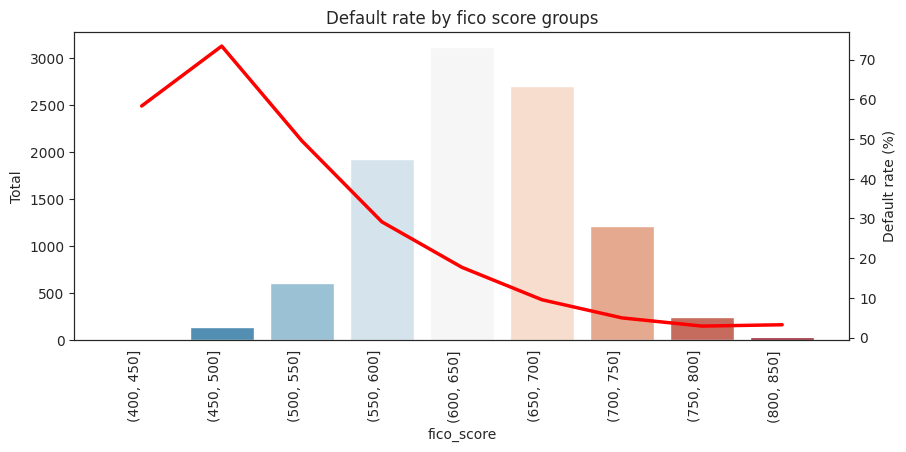

In [12]:
sns.set_style('white')
df_grouped = df.groupby([pd.cut(df['fico_score'],np.arange(400, 900, 50)),'default']).size()
df_grouped1 = df_grouped.groupby(level = 0).apply(lambda x:x/x.sum() * 100).unstack(level = 'default').reset_index()
df_grouped1['Default rate (%)'] = df_grouped1[1]
df_grouped = df_grouped.groupby(level = 0).apply(lambda x: x).unstack(level = 'default').reset_index()
df_grouped['Total'] = df_grouped[0]+df_grouped[1]
fig, ax1 = plt.subplots(figsize = (10,4))
sns.barplot(data = df_grouped, x = 'fico_score', y = 'Total', ax= ax1, palette = 'RdBu_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
ax2 = ax1.twinx()
sns.lineplot(data = df_grouped1, x = df_grouped1['fico_score'].astype(str), y='Default rate (%)', ax = ax2, color = 'r', linewidth = 2.5).set(title = 'Default rate by fico score groups')
plt.show()

<Axes: >

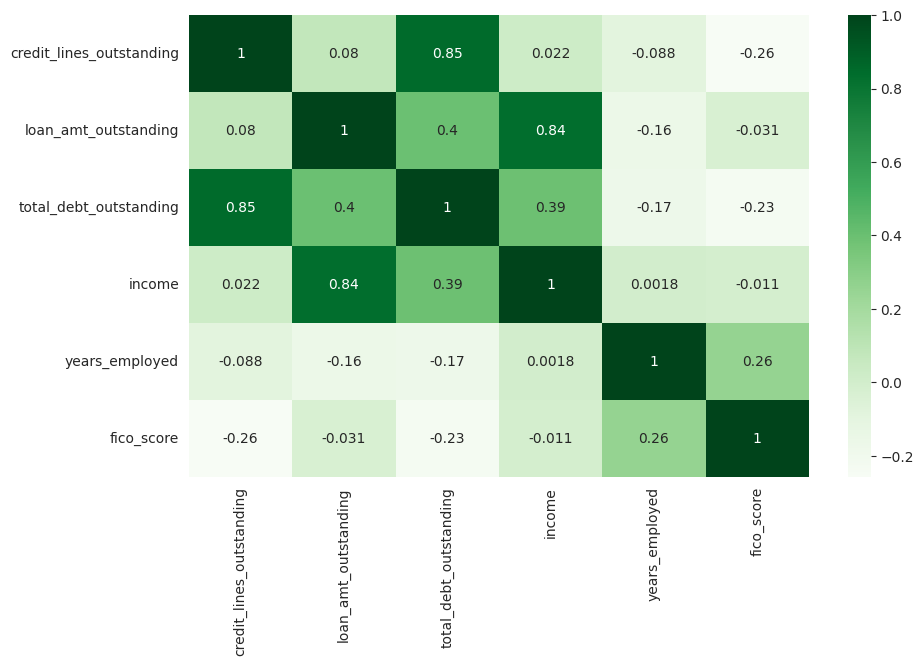

In [13]:
correlation_features = ['credit_lines_outstanding','loan_amt_outstanding','total_debt_outstanding','income','years_employed','fico_score']
ccorrelation_Transaction = df[correlation_features].corr()
plt.subplots(figsize = (10, 6))
sns.heatmap(ccorrelation_Transaction,annot=True, cmap = 'Greens')

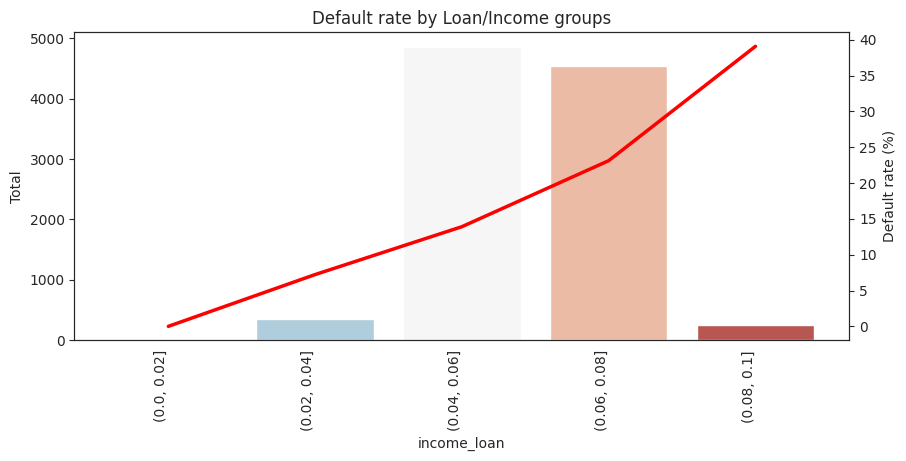

In [19]:
# To creat a new variable, to combine 'income' and 'loan_amount' together
df['income_loan'] = df['loan_amt_outstanding']/df['income']
sns.set_style('white')
df_grouped = df.groupby([pd.cut(df['income_loan'],np.arange(0, 0.12, 0.02)),'default']).size()
df_grouped1 = df_grouped.groupby(level = 0).apply(lambda x:x/x.sum() * 100).unstack(level = 'default').reset_index()
df_grouped1['Default rate (%)'] = df_grouped1[1]
df_grouped = df_grouped.groupby(level = 0).apply(lambda x: x).unstack(level = 'default').reset_index()
df_grouped['Total'] = df_grouped[0]+df_grouped[1]
fig, ax1 = plt.subplots(figsize = (10,4))
sns.barplot(data = df_grouped, x = 'income_loan', y = 'Total', ax= ax1, palette = 'RdBu_r')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
ax2 = ax1.twinx()
sns.lineplot(data = df_grouped1, x = df_grouped1['income_loan'].astype(str), y='Default rate (%)', ax = ax2, color = 'r', linewidth = 2.5).set(title = 'Default rate by Loan/Income groups')
plt.show()

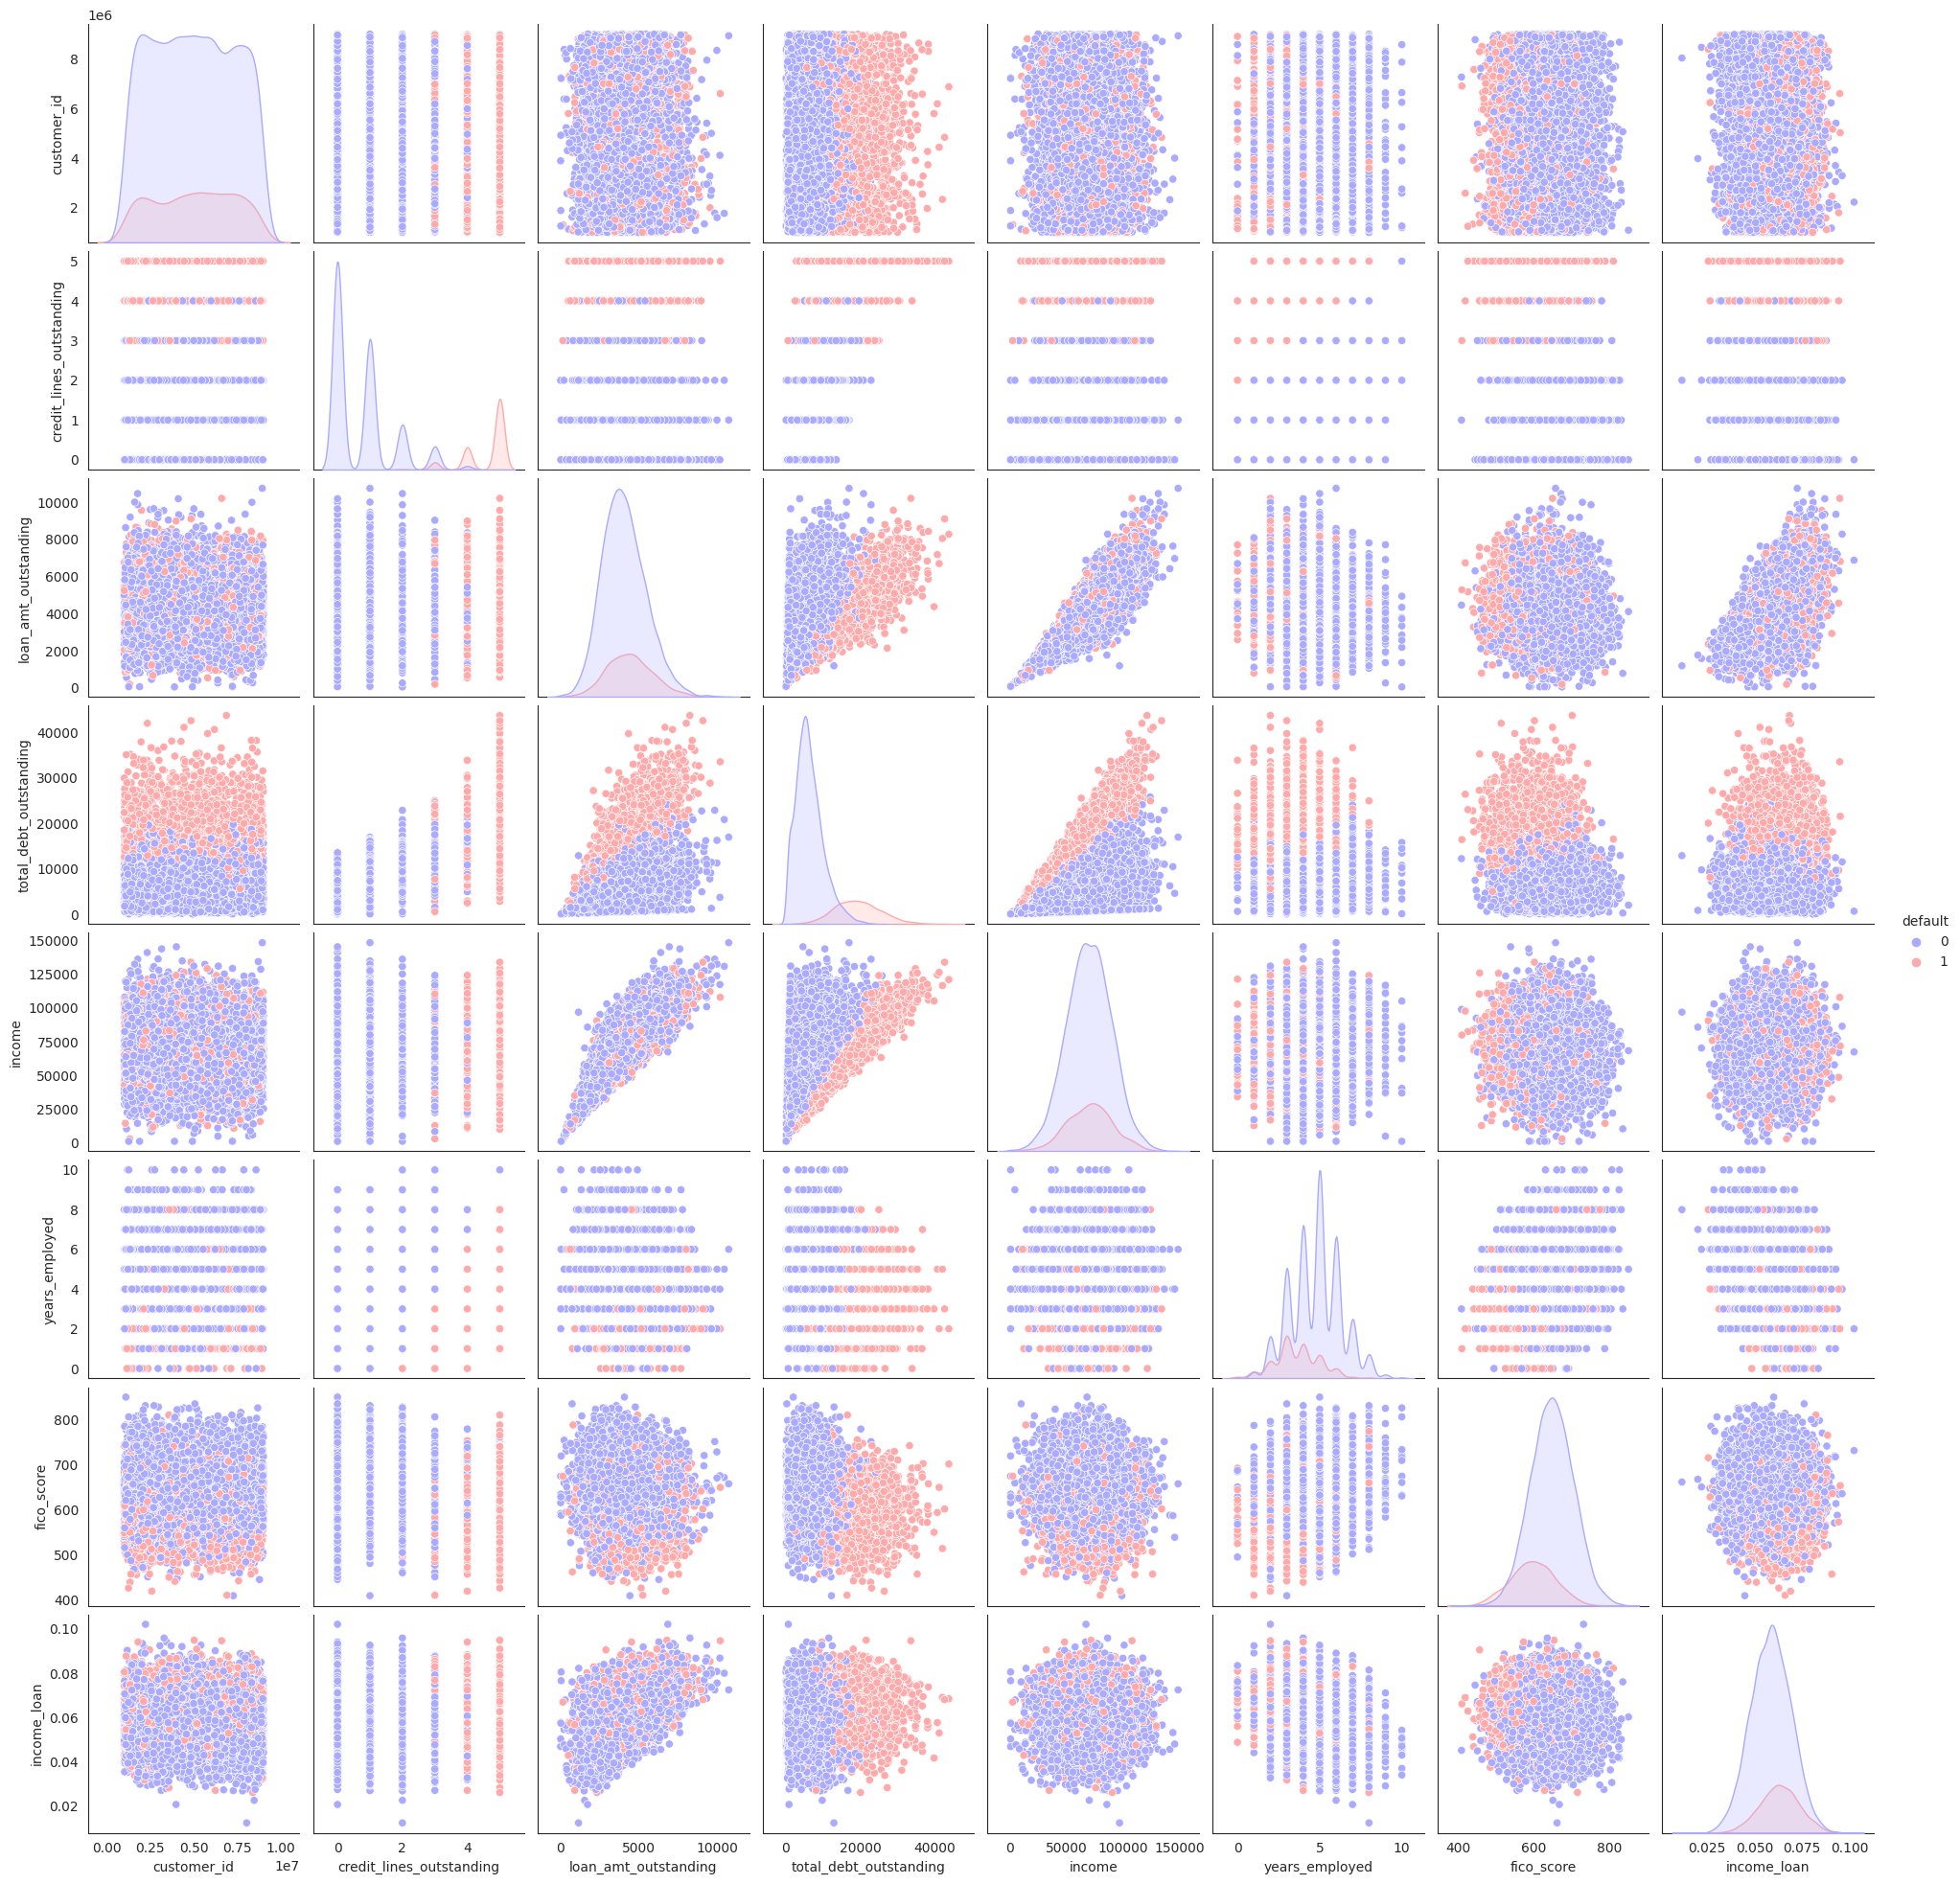

In [22]:
sns.pairplot(data=df, hue='default', palette='bwr')

# Building a Logistic Regression model

In [37]:
trainX = df[['credit_lines_outstanding','loan_amt_outstanding','total_debt_outstanding','income','years_employed','fico_score']]
trainY = df[['default']]
X_train, X_test, Y_train, Y_test = train_test_split(trainX, trainY, test_size = 0.30, random_state = 20)

In [38]:
logmodel = LogisticRegression(max_iter = 500)
logmodel.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

In [39]:
Predictions = logmodel.predict(X_test)

In [40]:
print(classification_report(Y_test, Predictions))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2455
           1       0.97      0.96      0.96       545

    accuracy                           0.99      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000



<Axes: >

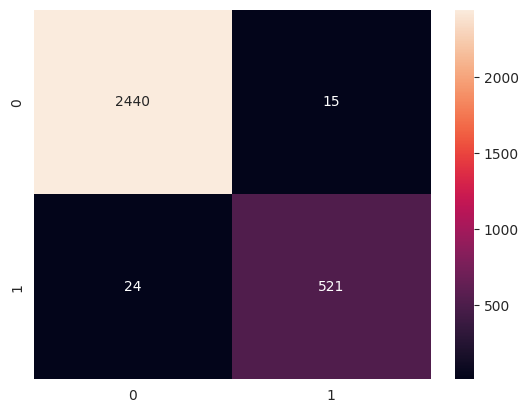

In [41]:
cm = confusion_matrix(Y_test, Predictions)
sns.heatmap(cm, annot=True, fmt='d')

In [42]:
print("Accuracy of the Logistic Regression model is: ", round(accuracy_score(Y_test, Predictions),2))

Accuracy of the Logistic Regression model is:  0.99


**if use the new variable load_income_ratio to replace these two varibles**

In [33]:
trainX = df[['credit_lines_outstanding','income_loan','total_debt_outstanding','years_employed','fico_score']]
trainY = df[['default']]
X_train, X_test, Y_train, Y_test = train_test_split(trainX, trainY, test_size = 0.30, random_state = 20)
logmodel = LogisticRegression(max_iter = 500)
logmodel.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

In [34]:
Predictions = logmodel.predict(X_test)
print(classification_report(Y_test, Predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2455
           1       0.99      0.99      0.99       545

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



<Axes: >

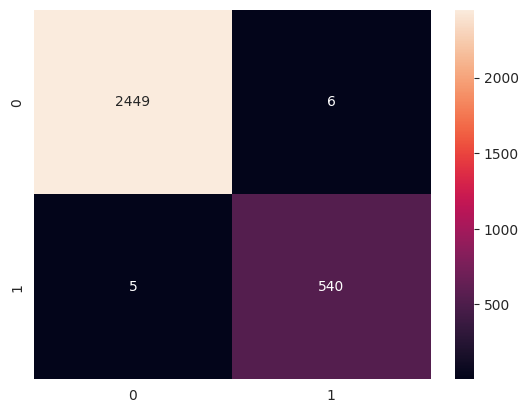

In [35]:
cm = confusion_matrix(Y_test, Predictions)
sns.heatmap(cm, annot=True, fmt='d')

In [36]:
print("Accuracy of the Logistic Regression model is: ", round(accuracy_score(Y_test, Predictions),2))

Accuracy of the Logistic Regression model is:  1.0


# To compare:

- **Before replace the variable:**
-
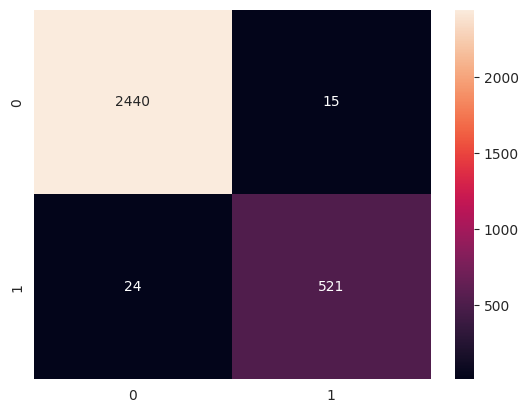


- **After replace the varible:**
-

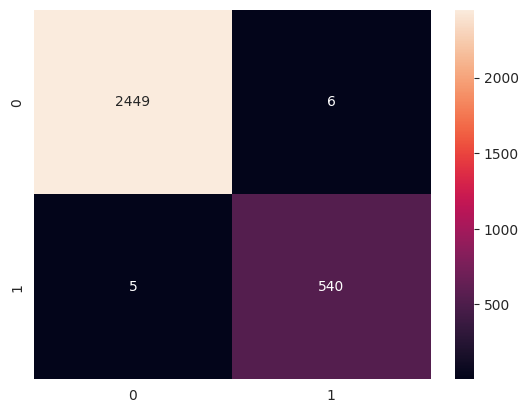

# Building a Random Forest Model

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [45]:
rfmodel = RandomForestClassifier(max_depth = 8, n_estimators = 100, random_state = 20)
rfmodel.fit(X_train, Y_train)

RandomForestClassifier(max_depth=8, random_state=20)

In [46]:
Predictions_rf = rfmodel.predict(X_test)
print(classification_report(Y_test, Predictions_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2455
           1       0.98      0.99      0.99       545

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000



<Axes: >

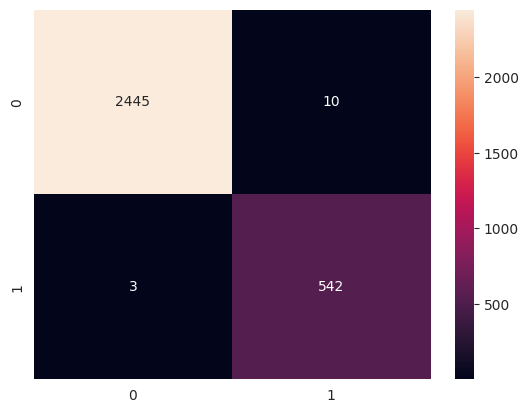

In [47]:
cm = confusion_matrix(Y_test, Predictions_rf)
sns.heatmap(cm, annot=True, fmt='d')

In [48]:
print('Accuracy of the Random Forest model is', round(accuracy_score(Y_test, Predictions_rf),2))

Accuracy of the Random Forest model is 1.0


In [49]:
importances = rfmodel.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print("{0:25} {1:6}".format(X_train.columns[i],round(importances[i],4)))

credit_lines_outstanding  0.5577
total_debt_outstanding    0.3065
years_employed            0.0513
fico_score                0.0369
income                    0.0338
loan_amt_outstanding      0.0139


# Building a XGBoost predictions

In [56]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder = False)
xgb_clf.fit(X_train, Y_train)
Predictions_xgb = xgb_clf.predict(X_test)
print(classification_report(Y_test, Predictions_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2455
           1       0.99      0.99      0.99       545

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000



<Axes: >

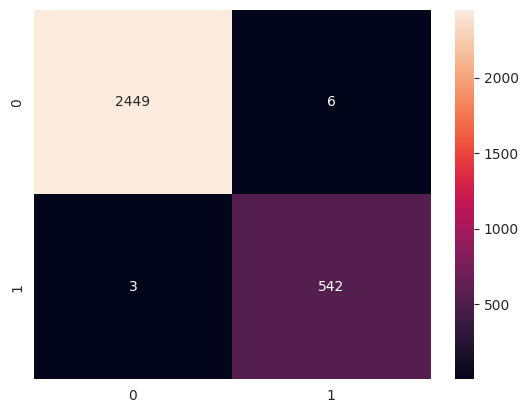

In [57]:
cm = confusion_matrix(Y_test, Predictions_xgb)
sns.heatmap(cm, annot=True, fmt='d')

# Compare Gini performance for both algorithms

The Gini coefficient is an industry standard measure of assessing the effectiveness of a scorecard in discriminating between good and bads.


Further details on how it's used and calculated :

https://towardsdatascience.com/clearly-explained-gini-coefficient-and-lorenz-curve-fe6f5dcdc07

https://www.thoughtco.com/calculate-the-gini-coefficient-1147711

In [52]:
# Function to calculate and plot gini curve
def plot_roc(y_true, scores_names):
    '''
    plot ROC curves for the specified model scores

            Parameters:
                    y_true (num): Target variable
                    scores_names (tuple): a tuple of model predictions and model label
    '''

    for score, label in scores_names:
        fpr, tpr, _ = roc_curve(y_true, y_score=score, drop_intermediate=False)
        AUC = roc_auc_score(y_true, score)
        gini = 2 * AUC - 1
        label = 'Gini = {:.2%},  {}'.format(gini, label)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0,1],[0,1], '--k')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.show();

In [59]:
# Calculate probability outcome to feed into Gini function
log_proba = logmodel.predict_proba(X_test)[:, 1]
rf_proba = rfmodel.predict_proba(X_test)[:, 1]
xgb_proba = xgb_clf.predict_proba(X_test)[:,1]

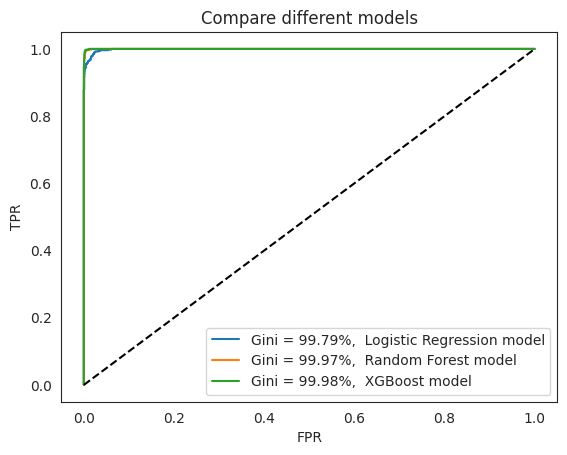

In [60]:
plt.title('Compare different models')
plot_roc(Y_test, [(log_proba, 'Logistic Regression model'), (rf_proba, 'Random Forest model'),(xgb_proba, 'XGBoost model')])